In [4]:
import sys
sys.path.insert(0, '../../')
from time import sleep

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')

from pyplr import stlab
from pyplr.calibrate import CalibrationContext

In [2]:
d = stlab.STLAB(username='admin', identity=1, password='83e47941d9e930f6')

STLAB device setup complete...


In [20]:
def interp_spectra(spectra):
    '''
    This function needs generalising.

    Parameters
    ----------
    spectra : TYPE
        DESCRIPTION.

    Returns
    -------
    intp_tbl : TYPE
        DESCRIPTION.

    '''
    #tbl = spectra.unstack(level=0)
    #tbl.columns = [val[1] for val in tbl.columns]
    
    intp_tbl = pd.DataFrame()
    for led, df in spectra.groupby(['led']):
        intensities = df.index.get_level_values('intensity')
        new_intensities = np.linspace(intensities.min(), intensities.max(), 4096)
        new_intensities = new_intensities.astype('int')
        df.reset_index(inplace=True, drop=True)
        #df.columns = range(0, df.shape[1])
        df.index = df.index * 63
        n = df.reindex(new_intensities).interpolate(method='linear')
        n['intensity'] = n.index
        n['led'] = led
        intp_tbl = intp_tbl.append(n)
    intp_tbl.set_index(['led','intensity'], inplace=True)
    return intp_tbl

In [27]:
cc = CalibrationContext('../data/S2_corrected_oo_spectra.csv', binwidth=1)
LED3_max = 1800 # comfortable maximal melanopsin stim
r_matches = {}
for led in [1,3,5,9]:
    match = cc.match(match_led=3, match_led_intensity=LED3_max, target_led=led, match_type='irrad')
    r_matches[led] = match

idxs = [(led,intensity[1]) for led, intensity in r_matches.items()]
stim_info = cc.aopic.loc[idxs]
stim_info['lux'] = cc.lux.loc[idxs]
stim_info['irradiance'] = cc.lkp.sum(axis=1)
stim_info.rename(columns={'irradiance':'Irradiance'}, inplace=True)
stim_info

,,S,M,L,Rods,Mel,lux,Irradiance
led,intensity,,,,,,,
1,1895,3.588587,0.619002,0.430505,1.713370,2.074132,176.148506,4.344407
3,1800,2.318395,1.320609,0.850208,2.878058,3.417057,413.571086,4.346396
5,1967,0.181596,3.450399,2.834834,3.427422,2.630284,1972.615648,4.347012
9,1451,0.046672,0.124562,0.669921,0.062031,0.056269,337.387354,4.344802


In [17]:
cc.lkp.loc[[(led, 4095) for led in range(10)]].max(axis=1)

led  intensity
0    4095         0.365679
1    4095         0.371801
2    4095         0.311165
3    4095         0.242114
4    4095         0.250241
5    4095         0.180836
6    4095         0.220115
7    4095         0.315748
8    4095         0.252011
9    4095         0.489332
dtype: float64

In [7]:
cc.lkp.loc[[(led, 4095) for led in range(10)]].idxmax(axis=1)

[(0, 4095),
 (1, 4095),
 (2, 4095),
 (3, 4095),
 (4, 4095),
 (5, 4095),
 (6, 4095),
 (7, 4095),
 (8, 4095),
 (9, 4095)]

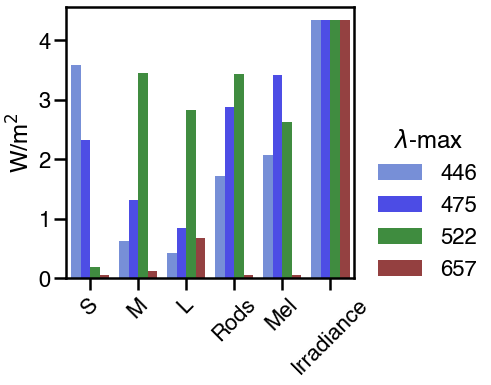

In [28]:
c = stlab.get_led_colors()
c = [c[i] for i in stim_info.index.get_level_values(0)]
d = stim_info.reset_index().melt(id_vars=['led','intensity'], 
                          value_name='flux',
                          var_name='aopic')
d = d[d.aopic!='lux']
fg = sns.catplot(x='aopic', 
                  y='flux', 
                  data=d, 
                  hue='led', 
                  kind='bar', 
                  palette=c, 
                  alpha=.8)
fg.set(xlabel='',
       ylabel='W/m$^2$')
plt.xticks(rotation=45)
fg._legend.set_title('$\lambda$-max')
fg._legend.set_bbox_to_anchor((1.1, .5))
new_labels = ['446', '475', '522', '657']
sns.despine(top=False, right=False)
for t, l in zip(fg._legend.texts, new_labels): 
    t.set_text(l)
fg.savefig('chirp_stims.tiff', dpi=300)


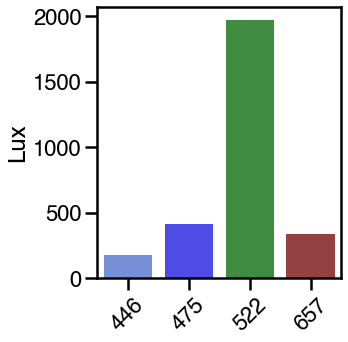

In [13]:
c = stlab.get_led_colors()
c = [c[i] for i in stim_info.index.get_level_values(0)]
d = stim_info.reset_index().melt(id_vars=['led','intensity'], 
                          value_name='flux',
                          var_name='aopic')
d = d[d.aopic=='lux']
fg = sns.catplot(x='led', 
                  y='flux', 
                  data=d, 
                  kind='bar', 
                  palette=c, 
                  alpha=.8,
                legend=False)
fg.set(xlabel='',
       ylabel='Lux',
       xticklabels=new_labels)
plt.xticks(rotation=45)
sns.despine(top=False, right=False)
plt.savefig('chirp_lux.tiff', dpi=300)

In [185]:
d

,led,intensity,aopic,flux
20,1,1559,lux,171.666063
21,3,1800,lux,474.484999
22,5,2039,lux,2125.065087
23,9,1322,lux,341.689773


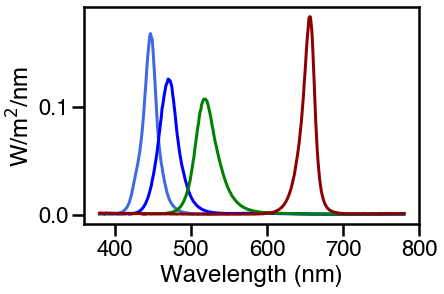

In [25]:
d = cc.lkp.loc[idxs].reset_index().melt(id_vars=['led','intensity'], 
                                        value_name='flux',
                                        var_name='Wavelength')
fig, ax = plt.subplots()
sns.lineplot(data=d, 
             x='Wavelength', 
             y='flux', 
             units='led', 
             estimator=None, 
             hue='led', 
             palette=c, 
             legend=False, 
             ax=ax)
ax.set(ylabel='W/m$^2$/nm',
      xlabel='Wavelength (nm)')
sns.despine(top=False, right=False)
fig.savefig('chirp_SPDs.tiff', dpi=300, bbox_inches='tight')


In [9]:
from scipy.signal import chirp

for (led, intensity), info in stim_info.iterrows():

    # stimulus params
    videoname = 'chirp_{}'.format(led)
    Fs = 100
    mintensity = 0
    maxtensity = intensity

    # stimulus params
    background  = maxtensity/2
    amplitude   = maxtensity/2
    duration = 20
    n = 2000
    t = np.linspace(0, duration, n, endpoint=False)
    f0 = 0.01
    f1 = 1

    # define frequency modulation
    chp = chirp(t, f0, duration, f1, method='linear', phi=270)
    chp = stlab.modulate_intensity_amplitude(chp, background, amplitude)
    #fig, ax = plt.subplots(figsize=(12,4))
    #ax.plot(chp)
    #ax.set_ylabel("Intensity")
    #ax.set_xlabel("Time")

    # define amplitude modulation
    time  = stlab.get_time_vector(duration)
    sm = stlab.sinusoid_modulation(.5, duration, Fs)
    ivals = stlab.modulate_intensity_amplitude(sm, background, np.linspace(0,amplitude,duration*Fs))
    #fig, ax = plt.subplots(figsize=(12,4))
    #ax.plot(ivals)
    #ax.set_ylabel("Intensity")
    #ax.set_xlabel("Time");

    duration=60
    time = stlab.get_time_vector(duration)
    stim = np.zeros(duration*Fs)

    # assemble time course
    stim[0:100]     = maxtensity # 1s pulse
    stim[800:900]   = background # step
    stim[900:2900]  = chp  # chirp
    stim[2900:3100] = background
    stim[3100:5100] = ivals
    stim[5100:5300] = background
    stim = stim.astype('int')

    # plot
    #fig, ax = plt.subplots(figsize=(16,4))
    #ax.plot(stim)
    #ax.set_ylabel("Intensity")
    #ax.set_xlabel("Time")

    # make video file
    cols = stlab.get_video_cols()
    zs = np.zeros(duration*Fs)
    zs = zs.astype('int')
    data = [zs for x in range(10)]
    data[led] = stim

    #data = [stim for x in range(10)]
    data.insert(0, time)
    df = pd.DataFrame(data, cols).T
    setting = {'led':led,'max_intensity':intensity}
    info = {**info.to_dict(), **setting}
    stlab.make_video_file(df, videoname, **info)

"chirp_1.dsf" saved in the current working directory.
"chirp_3.dsf" saved in the current working directory.
"chirp_5.dsf" saved in the current working directory.
"chirp_9.dsf" saved in the current working directory.


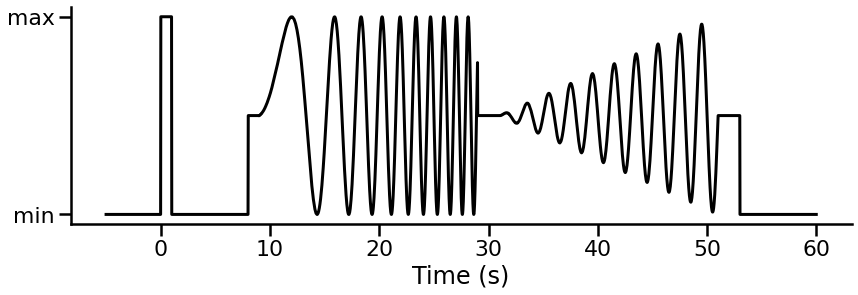

In [15]:
#stim = np.hstack([np.zeros(500),stim])
fig, ax = plt.subplots(figsize=(14,4))
ax.plot(np.arange(0, len(stim)), stim, c='k')
plt.xlabel('Time (s)')
plt.yticks([0,1322],['min','max'])
plt.xticks(range(500, 7000, 1000), [str(val) for val in range(0, 70, 10)])
sns.despine()
plt.savefig('chirp_profile.svg', bbox_inches='tight')

In [8]:
import glob
from time import sleep

for chp in glob.glob('chirp_*.dsf'):
    d.load_video_file(chp)
    d.play_video_file()
    sleep(60)

video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...
video file loaded...
playing video file...


In [28]:
glob.glob('chirp_*.dsf')

['chirp_4.dsf',
 'chirp_5.dsf',
 'chirp_7.dsf',
 'chirp_6.dsf',
 'chirp_2.dsf',
 'chirp_3.dsf',
 'chirp_1.dsf',
 'chirp_0.dsf',
 'chirp_8.dsf',
 'chirp_9.dsf']